**dgm**

**General**

In [1]:
import os
import time
from urllib.request import urlretrieve
import math
import argparse

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
#

In [3]:
class OPT_Base:
    pass


class Loader:
    def load(self):
        pass

    @staticmethod
    def download(url, dest):
        urlretrieve(url, dest)


class TrainPredict:
    def train(self, opt):
        pass

    def test(self, x_test, y_test):
        pass


class CalcKld:
    def calc(self, generated_data, ground_truth, bins, range_min, range_max):
        pass


class GAN:
    def train(self, x_train, y_train, x_val, y_val):
        pass

    def test(self, x_test, y_test):
        pass


class PredictService:
    def predict(self, x):
        pass

In [4]:
#

In [5]:
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt

In [6]:
def plot_train(predict, original, hist):
  fig = plt.figure()
  fig.subplots_adjust(hspace=0.2, wspace=0.2)

  plt.subplot(1, 2, 1)
  ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
  ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
  ax.set_title('Stock price', size = 14, fontweight='bold')
  ax.set_xlabel("Days", size = 14)
  ax.set_ylabel("Cost (USD)", size = 14)
  ax.set_xticklabels('', size=10)


  plt.subplot(1, 2, 2)
  ax = sns.lineplot(data=hist, color='royalblue')
  ax.set_xlabel("Epoch", size = 14)
  ax.set_ylabel("Loss", size = 14)
  ax.set_title("Training Loss", size = 14, fontweight='bold')
  fig.set_figheight(6)
  fig.set_figwidth(16)

**Analyzing**

In [7]:
class Loader_Amzn_Simple(Loader):
    def __init__(self, data_dir, data_source_path, lookback, scaler):
        self.data_dir = data_dir
        self.data_source_path = data_source_path
        self.lookback = lookback
        self.scaler = scaler

    def download_data(self):
        if not os.path.exists(self.data_dir):
            os.makedirs(self.data_dir)
        if not os.path.exists(self.data_source_path):
            url = "https://raw.githubusercontent.com/szrlee/Stock-Time-Series-Analysis/master/data/AMZN_2006-01-01_to_2018-01-01.csv"
            Loader.download(url, self.data_source_path)

        return pd.read_csv(self.data_source_path)

    def prepare_data(self, data):
        stock = data[['Close']]
        if self.scaler is not None:
            data['Close'] = self.scaler.fit_transform(data['Close'].values.reshape(-1, 1))
        stock = data[['Close']]

        d_raw = stock.to_numpy()
        d = []

        for index in range(len(d_raw) - self.lookback):
            d.append(d_raw[index: index + self.lookback])

        return np.array(d)

    def load(self):
        self.download_data()
        data = pd.read_csv(self.data_source_path)
        d = self.prepare_data(data)
        s = data.shape[0]
        test_set_size = int(np.round(0.2 * s))
        train_val_set_size = s - test_set_size
        val_set_size = int(np.round(0.2 * train_val_set_size))
        train_set_size = train_val_set_size - val_set_size

        x_train = d[:train_set_size, :-1]
        y_train = d[:train_set_size, -1, :]

        x_val = d[train_set_size:(train_set_size + val_set_size), :-1]
        y_val = d[train_set_size:(train_set_size + val_set_size), -1, :]

        x_test = d[(train_set_size + val_set_size):, :-1]
        y_test = d[(train_set_size + val_set_size):, -1, :]

        return x_train, y_train, x_val, y_val, x_test, y_test

In [8]:
class OPT_Simple(OPT_Base):
    def __init__(self):
        self.data_dir = "./data"
        self.data_source_path = self.data_dir + "/" + "AMZN_2006-01-01_to_2018-01-01.csv"

In [9]:
simple_opt = OPT_Simple()
simple_lookback = 20
simple_scaler = MinMaxScaler(feature_range=(-1, 1))
simple_loader = Loader_Amzn_Simple(simple_opt.data_dir, simple_opt.data_source_path, simple_lookback, simple_scaler)
s_x_train, s_y_train, s_x_val, s_y_val, s_x_test, s_y_test = simple_loader.load()
print(
        "{}, {}, {}, {}, {}, {}".format(s_x_train.shape, s_y_train.shape, s_x_val.shape, s_y_val.shape, s_x_test.shape,
                                        s_y_test.shape))
print(s_x_train[:1])

(1932, 19, 1), (1932, 1), (483, 19, 1), (483, 1), (584, 19, 1), (584, 1)
[[[-0.96322323]
  [-0.96378744]
  [-0.96310354]
  [-0.9627274 ]
  [-0.9640781 ]
  [-0.96652305]
  [-0.96775407]
  [-0.96872863]
  [-0.96866024]
  [-0.96934414]
  [-0.96879702]
  [-0.96857475]
  [-0.96948092]
  [-0.96980577]
  [-0.96930994]
  [-0.97002804]
  [-0.96818151]
  [-0.96725824]
  [-0.96770278]]]


In [10]:
simple_data = simple_loader.download_data()

In [11]:
simple_data.head(2)

Date   Open   High    Low  Close   Volume  Name
0  2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
1  2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN

**Baseline. LSTM_M**

In [12]:
class LSTM_M(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM_M, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out


class LSTM_M_GAN(GAN):
    def __init__(self, scaler):
        input_dim = 1
        hidden_dim = 32
        num_layers = 2
        output_dim = 1
        self.num_epochs = 100
        self.model = LSTM_M(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
        self.scaler = scaler

    def train(self, x_train, y_train, x_val, y_val):
        #
        x_train = torch.from_numpy(x_train).type(torch.Tensor)
        x_test = torch.from_numpy(x_val).type(torch.Tensor)
        y_train = torch.from_numpy(y_train).type(torch.Tensor)
        y_test = torch.from_numpy(y_val).type(torch.Tensor)
        #
        model = self.model
        #
        criterion = torch.nn.MSELoss(reduction='mean')
        optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
        #
        hist = np.zeros(self.num_epochs)
        start_time = time.time()
        lstm = []
        for t in range(self.num_epochs):
            y_train_pred = model(x_train)

            loss = criterion(y_train_pred, y_train)
            if t % 20 == 0:
                print("Epoch: ", t, ".", "MSE: ", loss.item(), ".")
            hist[t] = loss.item()

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
        training_time = time.time() - start_time

        print("Training time: {}. MSE: {}.".format(training_time, hist[-1]))

        return y_train_pred, hist

    def test(self, x_test, y_test):
        x_test = torch.from_numpy(x_test).type(torch.Tensor)
        y_test_pred = self.model(x_test)

        y_test_pred = LSTM_M_GAN.transform_data(y_test_pred, self.scaler)

        mse = math.sqrt(mean_squared_error(y_test, y_test_pred))

        return mse

    @staticmethod
    def transform_data(df, scaler):
        if scaler is not None:
            return pd.DataFrame(scaler.inverse_transform(df.detach().numpy()))
        return pd.DataFrame(df.detach().numpy())

    @staticmethod
    def transform_data_pd(df, scaler):
        if scaler is not None:
            return pd.DataFrame(scaler.inverse_transform(df))
        return pd.DataFrame(df)

In [13]:
lstm_m_gan = LSTM_M_GAN(simple_scaler)

In [14]:
lstm_m_y_train_pred, lstm_m_hist = lstm_m_gan.train(s_x_train, s_y_train, s_x_val, s_y_val)

Epoch:  0 . MSE:  0.6503024101257324 .
Epoch:  20 . MSE:  0.023588191717863083 .
Epoch:  40 . MSE:  0.016649069264531136 .
Epoch:  60 . MSE:  0.010942576453089714 .
Epoch:  80 . MSE:  0.0008845865377224982 .
Training time: 19.178718328475952. MSE: 0.0001964506518561393.


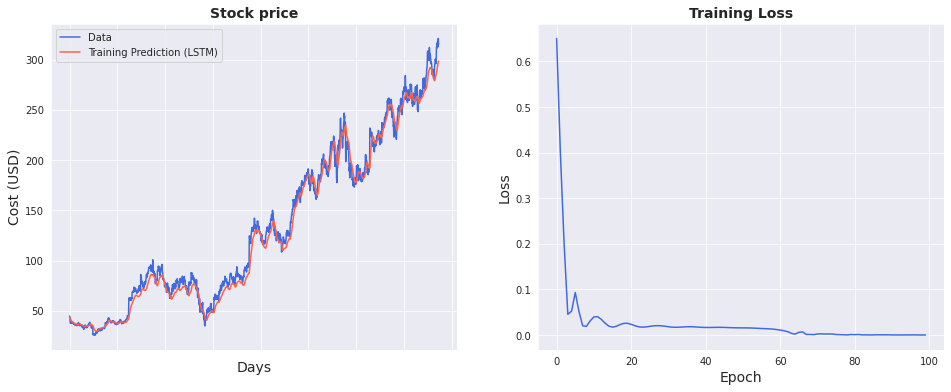

In [15]:
plot_train(LSTM_M_GAN.transform_data(lstm_m_y_train_pred, simple_scaler), LSTM_M_GAN.transform_data_pd(s_y_train, simple_scaler), lstm_m_hist)

In [16]:
lstm_m_test_rmse = lstm_m_gan.test(s_x_test, s_y_test)

In [17]:
print(round(lstm_m_test_rmse, 4))

444.7578


In [18]:
#

**ForGAN**

In [19]:
class OPT(OPT_Base):
    def __init__(self, opt_main=None):
        self.data_dir = "./data"
        self.data_source_path = self.data_dir + "/" + "AMZN_2006-01-01_to_2018-01-01.csv"
        self.dataset = "amzn"
        self.data_mean = None
        self.data_std = None
        self.noise_size = 32
        self.condition_size = 24
        self.generator_latent_size = 8
        self.cell_type = "gru"
        self.discriminator_latent_size = 64
        self.lr = 0.001
        self.n_steps = 2400
        self.d_iter = 2
        self.batch_size = 1000
        self.hist_bins = 80
        self.hist_min = -1600
        self.hist_max = 1600
        torch.manual_seed(1368)

In [20]:
class Loader_Amzn(Loader):
    def __init__(self, data_dir, data_source_path, condition_size):
        self.data_dir = data_dir
        self.data_source_path = data_source_path
        self.condition_size = condition_size

    def download_data(self):
        if not os.path.exists(self.data_dir):
            os.makedirs(self.data_dir)
        if not os.path.exists(self.data_source_path):
            url = "https://raw.githubusercontent.com/szrlee/Stock-Time-Series-Analysis/master/data/AMZN_2006-01-01_to_2018-01-01.csv"
            Loader.download(url, self.data_source_path)

    def load(self):
        self.download_data()
        ds = pd.read_csv(self.data_source_path)
        ds_ = ds[['Close']]

        raw_dataset = ds_
        raw_dataset = np.transpose(raw_dataset.values)[0]

        x = [raw_dataset[i - self.condition_size:i] for i in range(self.condition_size, raw_dataset.shape[0])]
        x = np.array(x)
        y = raw_dataset[self.condition_size:]

        x_train = x[:int(x.shape[0] * 0.5)]
        y_train = y[:int(x.shape[0] * 0.5)]
        x_val = x[int(x.shape[0] * 0.5):int(x.shape[0] * 0.6)]
        y_val = y[int(x.shape[0] * 0.5):int(x.shape[0] * 0.6)]
        x_test = x[int(x.shape[0] * 0.6):]
        y_test = y[int(x.shape[0] * 0.6):]
        return x_train, y_train, x_val, y_val, x_test, y_test

In [21]:
class CalcKldSimple(CalcKld):
    def calc(self, generated_data, ground_truth, bins, range_min, range_max):
        pd_gt, _ = np.histogram(ground_truth, bins=bins, density=True, range=(range_min, range_max))
        pd_gen, _ = np.histogram(generated_data, bins=bins, density=True,
                                 range=(range_min, range_max))
        kld = 0
        for x1, x2 in zip(pd_gt, pd_gen):
            if x1 != 0 and x2 == 0:
                kld += x1
            elif x1 == 0 and x2 != 0:
                kld += x2
            elif x1 != 0 and x2 != 0:
                kld += x1 * np.log(x1 / x2)

        return np.abs(kld)

In [22]:
class GAN_Forgan_Generator(nn.Module):
    def __init__(self, noise_size, condition_size, generator_latent_size, cell_type, mean=0, std=1):
        super().__init__()

        self.noise_size = noise_size
        self.condition_size = condition_size
        self.generator_latent_size = generator_latent_size
        self.mean = mean
        self.std = std

        if cell_type == "lstm":
            self.cond_to_latent = nn.LSTM(input_size=1,
                                          hidden_size=generator_latent_size)
        else:
            self.cond_to_latent = nn.GRU(input_size=1,
                                         hidden_size=generator_latent_size)

        self.model = nn.Sequential(
            nn.Linear(in_features=generator_latent_size + self.noise_size,
                      out_features=generator_latent_size + self.noise_size),
            nn.ReLU(),
            nn.Linear(in_features=generator_latent_size + self.noise_size, out_features=1)

        )

    def forward(self, noise, condition):
        condition = (condition - self.mean) / self.std
        condition = condition.view(-1, self.condition_size, 1)
        condition = condition.transpose(0, 1)
        condition_latent, _ = self.cond_to_latent(condition)
        condition_latent = condition_latent[-1]
        g_input = torch.cat((condition_latent, noise), dim=1)
        output = self.model(g_input)
        output = output * self.std + self.mean

        return output

    def get_noise_size(self):
        return self.noise_size

In [23]:
class GAN_Forgan_Discriminator(nn.Module):
    def __init__(self, condition_size, discriminator_latent_size, cell_type, mean=0, std=1):
        super().__init__()
        self.discriminator_latent_size = discriminator_latent_size
        self.condition_size = condition_size
        self.mean = mean
        self.std = std

        if cell_type == "lstm":
            self.input_to_latent = nn.LSTM(input_size=1,
                                           hidden_size=discriminator_latent_size)
        else:
            self.input_to_latent = nn.GRU(input_size=1,
                                          hidden_size=discriminator_latent_size)

        self.model = nn.Sequential(
            nn.Linear(in_features=discriminator_latent_size, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, prediction, condition):
        d_input = torch.cat((condition, prediction.view(-1, 1)), dim=1)
        d_input = (d_input - self.mean) / self.std
        d_input = d_input.view(-1, self.condition_size + 1, 1)
        d_input = d_input.transpose(0, 1)
        d_latent, _ = self.input_to_latent(d_input)
        d_latent = d_latent[-1]
        output = self.model(d_latent)
        return output

In [24]:
class ForGAN(GAN):
    def __init__(self, opt, calc_kld=CalcKldSimple()):
        self.opt = opt
        self.device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
        print("*****  Hyper-parameters  *****")
        for k, v in vars(opt).items():
            print("{}:\t{}".format(k, v))
        print("************************")

        # Making required directories for logging, plots and models' checkpoints
        try:
            os.remove('./' + self.opt.dataset + '/best.torch')
        except OSError:
            pass

        os.makedirs("./{}/".format(self.opt.dataset), exist_ok=True)

        # Defining GAN components
        self.generator = GAN_Forgan_Generator(noise_size=opt.noise_size,
                                              condition_size=opt.condition_size,
                                              generator_latent_size=opt.generator_latent_size,
                                              cell_type=opt.cell_type,
                                              mean=opt.data_mean,
                                              std=opt.data_std)

        self.discriminator = GAN_Forgan_Discriminator(condition_size=opt.condition_size,
                                                      discriminator_latent_size=opt.discriminator_latent_size,
                                                      cell_type=opt.cell_type,
                                                      mean=opt.data_mean,
                                                      std=opt.data_std)

        self.generator = self.generator.to(self.device)
        self.discriminator = self.discriminator.to(self.device)
        print("\nNetwork Architecture\n")
        print(self.generator)
        print(self.discriminator)
        print("\n************************\n")
        self.rs = np.random.RandomState(1368)
        self.calc_kld = calc_kld

    def train(self, x_train, y_train, x_val, y_val):
        x_train = torch.tensor(x_train, device=self.device, dtype=torch.float32)
        y_train = torch.tensor(y_train, device=self.device, dtype=torch.float32)
        x_val = torch.tensor(x_val, device=self.device, dtype=torch.float32)
        best_kld = np.inf
        optimizer_g = torch.optim.RMSprop(self.generator.parameters(), lr=self.opt.lr)
        optimizer_d = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.opt.lr)
        adversarial_loss = nn.BCELoss()
        adversarial_loss = adversarial_loss.to(self.device)

        g_loss_list = []

        rs = self.rs
        for step in range(self.opt.n_steps):
            d_loss = 0
            for _ in range(self.opt.d_iter):
                # train discriminator on real data
                idx = rs.choice(x_train.shape[0], self.opt.batch_size)
                condition = x_train[idx]
                real_data = y_train[idx]
                self.discriminator.zero_grad()
                d_real_decision = self.discriminator(real_data, condition)
                d_real_loss = adversarial_loss(d_real_decision,
                                               torch.full_like(d_real_decision, 1, device=self.device))
                d_real_loss.backward()
                d_loss += d_real_loss.detach().cpu().numpy()
                # train discriminator on fake data
                noise_batch = torch.tensor(rs.normal(0, 1, (condition.size(0), self.opt.noise_size)),
                                           device=self.device, dtype=torch.float32)
                x_fake = self.generator(noise_batch, condition).detach()
                d_fake_decision = self.discriminator(x_fake, condition)
                d_fake_loss = adversarial_loss(d_fake_decision,
                                               torch.full_like(d_fake_decision, 0, device=self.device))
                d_fake_loss.backward()

                optimizer_d.step()
                d_loss += d_fake_loss.detach().cpu().numpy()

            d_loss = d_loss / (2 * self.opt.d_iter)

            self.generator.zero_grad()
            noise_batch = torch.tensor(rs.normal(0, 1, (self.opt.batch_size, self.opt.noise_size)), device=self.device,
                                       dtype=torch.float32)
            x_fake = self.generator(noise_batch, condition)
            d_g_decision = self.discriminator(x_fake, condition)
            # Mackey-Glass works best with Minmax loss in our expriements while other dataset
            # produce their best result with non-saturated loss
            if self.opt.dataset == "mg":
                g_loss = adversarial_loss(d_g_decision, torch.full_like(d_g_decision, 1, device=self.device))
            else:
                g_loss = -1 * adversarial_loss(d_g_decision, torch.full_like(d_g_decision, 0, device=self.device))
            g_loss.backward()
            optimizer_g.step()

            g_loss = g_loss.detach().cpu().numpy()

            # Validation
            noise_batch = torch.tensor(rs.normal(0, 1, (x_val.size(0), self.opt.noise_size)), device=self.device,
                                       dtype=torch.float32)
            preds = self.generator(noise_batch, x_val).detach().cpu().numpy().flatten()

            kld = self.calc_kld.calc(preds, y_val, self.opt.hist_bins, self.opt.hist_min, self.opt.hist_max)

            if kld <= best_kld and kld != np.inf:
                best_kld = kld
                print("step : {} , KLD : {}, RMSE : {}".format(step, best_kld,
                                                               np.sqrt(np.square(preds - y_val).mean())))
                torch.save({
                    'g_state_dict': self.generator.state_dict()
                }, "./{}/best.torch".format(self.opt.dataset))

            if step % 100 == 0:
                print("step : {} , d_loss : {} , g_loss : {} , kld : {}, best_kld : {}".format(step, d_loss,
                                                                                               g_loss, kld,
                                                                                               best_kld))

            g_loss_list.append(np.mean(g_loss))

        return preds, g_loss_list

    def test(self, x_test, y_test):
        x_test = torch.tensor(x_test, device=self.device, dtype=torch.float32)
        checkpoint = torch.load("./{}/best.torch".format(self.opt.dataset))
        self.generator.load_state_dict(checkpoint['g_state_dict'])
        y_test = y_test.flatten()
        preds = []
        rmses = []
        maes = []
        mapes = []
        rs = self.rs
        for _ in range(200):
            noise_batch = torch.tensor(rs.normal(0, 1, (x_test.size(0), self.opt.noise_size)), device=self.device,
                                       dtype=torch.float32)
            pred = self.generator(noise_batch, x_test).detach().cpu().numpy().flatten()
            preds.append(pred)

            error = pred - y_test
            rmses.append(np.sqrt(np.square(error).mean()))
            maes.append(np.abs(error).mean())
            mapes.append(np.abs(error / y_test).mean() * 100)
        preds = np.vstack(preds)
        crps = np.absolute(preds[:100] - y_test).mean() - 0.5 * np.absolute(preds[:100] - preds[100:]).mean()
        preds = preds.flatten()
        kld = self.calc_kld.calc(preds, y_test, self.opt.hist_bins, self.opt.hist_min, self.opt.hist_max)
        print("Test resuts:\nRMSE : {}({})\nMAE : {}({})\nMAPE : {}({}) %\nCRPS : {}\nKLD : {}\n"
              .format(np.mean(rmses), np.std(rmses),
                      np.mean(maes), np.std(maes),
                      np.mean(mapes), np.std(mapes),
                      crps,
                      kld))
        return np.mean(rmses)

In [25]:
class ForGANTrainPredict(TrainPredict):
    def __init__(self):
        self.forgan = None

    def train(self, opt, calc_kld=CalcKldSimple()):
        data_dir = opt.data_dir
        data_source_path = opt.data_source_path
        condition_size = opt.condition_size
        loader = Loader_Amzn(data_dir, data_source_path, condition_size)
        x_train, y_train, x_val, y_val, x_test, y_test = loader.load()
        opt.data_mean = x_train.mean()
        opt.data_std = x_train.std()
        self.forgan = ForGAN(opt, calc_kld)
        y_train_pred, hist = self.forgan.train(x_train, y_train, x_val, y_val)
        return {
            "y_train_pred": y_train_pred,
            "hist": hist,
            "x_train": x_train,
            "y_train": y_train,
            "x_val": x_val,
            "y_val": y_val,
            "x_test": x_test,
            "y_test": y_test
        }

    def test(self, x_test, y_test):
        rmse = self.forgan.test(x_test, y_test)
        return {
            "rmse": rmse
        }

In [26]:
class SolutionConfig:
    @staticmethod
    def create_opt(opt_main=None):
        return OPT(opt_main)

In [27]:
class ForGANPredictService(PredictService):
    def __init__(self, opt):
        self.opt = opt
        self.device = torch.device("cpu") # torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

        self.generator = GAN_Forgan_Generator(noise_size=opt.noise_size,
                                              condition_size=opt.condition_size,
                                              generator_latent_size=opt.generator_latent_size,
                                              cell_type=opt.cell_type,
                                              mean=opt.data_mean,
                                              std=opt.data_std)
        self.loaded = False
        self.rs = np.random.RandomState(1368)

    def predict(self, x):
        if not self.loaded:
            self.loaded = True
            checkpoint = torch.load("./{}/best.torch".format(self.opt.dataset))
            self.generator.load_state_dict(checkpoint['g_state_dict'])
        x_t = torch.tensor(x, device=self.device, dtype=torch.float32)
        noise_batch = torch.tensor(self.rs.normal(0, 1, (x_t.size(0), self.opt.noise_size)), device=self.device,
                                   dtype=torch.float32)
        pred = self.generator(noise_batch, x_t).detach().cpu().numpy().flatten()
        return pred

    def predict_next(self, data_mean=1000.0, data_std=60.0, n=10):
        self.opt.data_mean = data_mean
        self.opt.data_std = data_std
        self.generator.mean = data_mean
        self.generator.std = data_std

        forgan_x_a = []
        for i in range(n):
            forgan_x = []
            fogran_x_0 = 0.0
            forgan_x.append(fogran_x_0)
            for i in range(23):
                x = np.random.uniform(0.1, 0.2)
                forgan_x.append(x)
            forgan_x_a.append(forgan_x)

        forgan_x = np.array(forgan_x_a)

        forgan_y = self.predict(forgan_x)
        return forgan_y

In [28]:
forgan = ForGANTrainPredict()
forgan_opt = SolutionConfig.create_opt()
calc_kld = CalcKldSimple()

In [29]:
f_train_results = forgan.train(forgan_opt, calc_kld)
f_x_test = f_train_results["x_test"]
f_y_test = f_train_results["y_test"]
f_y_val = f_train_results["y_val"]
f_x_val = f_train_results["x_val"]
f_y_train_pred = f_train_results["y_train_pred"]
f_hist = f_train_results["hist"]

*****  Hyper-parameters  *****
data_dir:	./data
data_source_path:	./data/AMZN_2006-01-01_to_2018-01-01.csv
dataset:	amzn
data_mean:	99.71257737697617
data_std:	56.390660406067944
noise_size:	32
condition_size:	24
generator_latent_size:	8
cell_type:	gru
discriminator_latent_size:	64
lr:	0.001
n_steps:	2400
d_iter:	2
batch_size:	1000
hist_bins:	80
hist_min:	-1600
hist_max:	1600
************************

Network Architecture

GAN_Forgan_Generator(
  (cond_to_latent): GRU(1, 8)
  (model): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=1, bias=True)
  )
)
GAN_Forgan_Discriminator(
  (input_to_latent): GRU(1, 64)
  (model): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

************************

step : 0 , KLD : 0.049999999999999996, RMSE : 137.6775684265081
step : 0 , d_loss : 0.6902747005224228 , g_loss : -0.6632006764411926 , kld : 0.049999999999999996, b

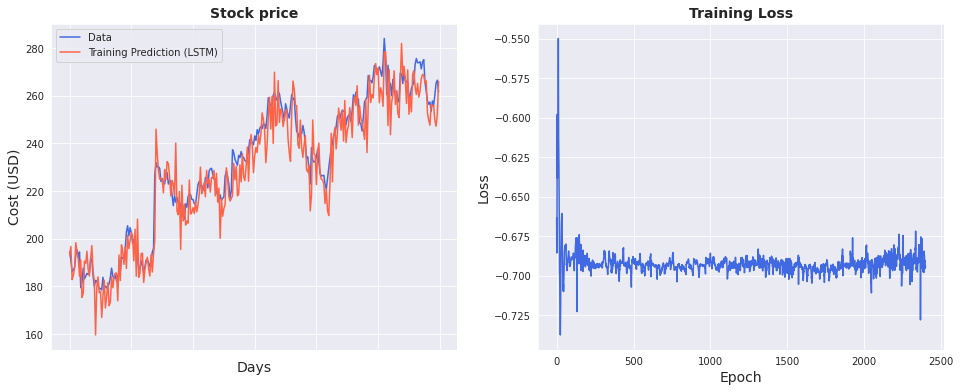

In [30]:
plot_train(pd.DataFrame(f_y_train_pred), pd.DataFrame(f_y_val), f_hist)

In [31]:
f_test_results = forgan.test(f_x_test, f_y_test)
f_rmse = f_test_results["rmse"]

Test resuts:
RMSE : 325.95914173163(0.11453576280921098)
MAE : 228.8919919604421(0.11075048148749615)
MAPE : 29.89905609543772(0.026793303326373523) %
CRPS : 226.53671084757184
KLD : 0.006775330174941235



In [32]:
print(round(f_rmse, 4))

325.9591


**Prediction & Results**

In [33]:
print("LSTM_M (rmse) ", round(lstm_m_test_rmse, 4), ".", "ForGAN (rmse)", round(f_rmse, 4))

LSTM_M (rmse)  444.7578 . ForGAN (rmse) 325.9591


**Prediction**

In [34]:
forgan_opt = SolutionConfig.create_opt()

In [35]:
forgan_predict_service = ForGANPredictService(forgan_opt)
forgan_predict_service.device

device(type='cpu')

In [66]:
forgan_predict_v = forgan_predict_service.predict_next(data_mean=480.0, data_std=60.0, n=10)
forgan_predict_v[:5]

array([276.0161 , 272.76758, 276.92462, 279.32626, 276.75616],
      dtype=float32)

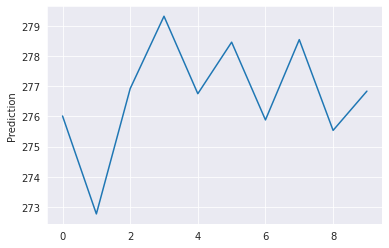

In [67]:
plt.plot(forgan_predict_v)
plt.ylabel('Prediction')
plt.show()

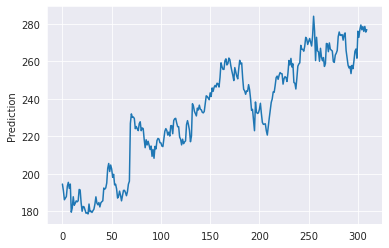

In [68]:
plt.plot(np.concatenate((f_y_val, forgan_predict_v)))
plt.ylabel('Prediction')
plt.show()